## Homework #2
**Michael Carrion, Vanessa Ma, Rahul Rangwani**

In [4]:
# Set up
import pandas as pd
import numpy as np
import time

data = pd.read_stata("data/CPS_2012_micro.dta")

In [5]:
np.random.seed(60356548)

# we draw the policy for each state
fpol = { k:np.random.uniform() > 0.5 for k in np.unique(data['statefip']) }
data['fp'] = data['statefip'].map(fpol)

data.head()

,year,statefip,wtsupp,age,sex,yrseduc,wage_per_hour,lnwage,age2,fp
0,2012,Maine,569.43,44,Female,14.0,7.020000,1.948763,1936.0,True
1,2012,Maine,595.47,25,Male,16.0,2.117143,0.750067,625.0,True
2,2012,Maine,635.66,61,Female,16.0,16.672501,2.813761,3721.0,True
3,2012,Maine,635.66,62,Male,16.0,17.784000,2.878299,3844.0,True
4,2012,Maine,513.39,25,Female,12.0,9.633000,2.265195,625.0,True


Question 1:<br>
1) Compute average wage in each state for each age decile <br>
2) Pivot table with states in rows and age deciles in columns <br>
3) Using pandas styling, highlight the lowest wage in each age decile, format average wage with only 2 decimal points

In [6]:
def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

def tibo_question1(data):
    data["decile"] = data["age"].astype(int) // 10 * 10 + 10
    wage_decile = pd.pivot_table(data, "wage_per_hour", index = "statefip", columns = "decile")
    wage_decile = wage_decile.style.\
        set_precision(2).\
        apply(highlight_min, axis = 0)
    return wage_decile

In [7]:
tibo_question1(data)

decile,20,30,40,50,60,70
statefip,,,,,,
Alabama,6.44,10.77,15.56,18.64,17.83,15.93
Alaska,7.16,13.30,19.42,19.41,21.18,20.19
Arizona,6.58,11.73,15.92,19.06,18.17,21.06
Arkansas,5.58,11.71,15.24,17.04,16.12,15.03
California,9.86,12.27,18.49,20.53,21.44,21.15
Colorado,12.25,11.98,18.52,20.66,21.93,21.72
Connecticut,4.55,12.96,20.50,23.96,25.66,21.75
Delaware,7.00,12.13,16.14,20.08,17.95,19.41
District of Columbia,24.08,16.56,25.57,25.43,25.74,28.26


In [7]:
# First Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

results = smf.ols('lnwage ~ fp', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnwage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.53
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           0.000687
Time:                        13:24:13   Log-Likelihood:                -62336.
No. Observations:               65685   AIC:                         1.247e+05
Df Residuals:                   65683   BIC:                         1.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6687      0.003    836.168      0.0

In [8]:
results.tvalues[1]

3.3949698497460123

Question 2: <br>
Follow the steps and report how often we would consider the coefficient on fp significant at 5%. You should find something close to 5% and you should feel better about the theory! <br>
1) compute the variance of lnwage in the sample. This is an estimate of our homoskedastic error. <br>
2) simulate a fictitious outcome y2 simply equal to normal error with the estimated variance, and truly independent across individuals. Use .assign(y2 = ...) on the pandas dataFrame. <br>
3) regress this outcome y2 on fp, our fictitious policy and collect the coefficient, also save if the coefficient is significant at 5%.<br>
4) run steps (2,3) 500 times.

In [19]:
# IID Errors
def tibo_question2(data):
    lnwage_var = data["lnwage"].var()
    tstats = []
    for iter in range(0, 500):
        data = data.assign(y2 = np.random.normal(0, np.sqrt(lnwage_var), len(data.index)))
        results = smf.ols('y2 ~ fp', data=data).fit()
        tstats.append(results.tvalues[1])
    return tstats

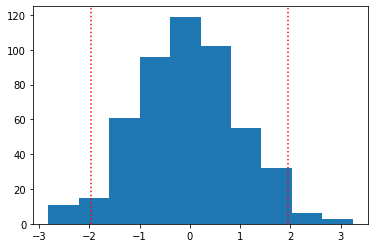

In [20]:
tstats = tibo_question2(data)
plt.hist(tstats)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

In [21]:
# I check that the distribution is outside of the 0.025 to 0.0975 quantiles 
# of the normal with probability close to 0.05
(np.abs(tstats)>1.96).mean()

0.048

Question 3: <br>
We go back and we do the same exercise, only this time we redraw the policy in each replciations and regress the wages on it, and collect the t-stats. We then plot the histogram of the t-stats and compute the probability of rejecting the null that the coefficient on the policy is 0. <br>
Replicate 500 times the very first regression to recreate an histogram of t-stats similar to the following one. Compute the probability to reject the null of effect and comment on its value given the way you simulated the data (2 sentences max).

In [24]:
def tibo_question3(data):
    tstats = []
    for iter in range(0, 500):
        fpol = { k:np.random.uniform() > 0.5 for k in np.unique(data['statefip']) }
        data = data.assign(fp = data['statefip'].map(fpol))
        results = smf.ols('lnwage ~ fp', data=data).fit()
        tstats.append(results.tvalues[1])
    return tstats

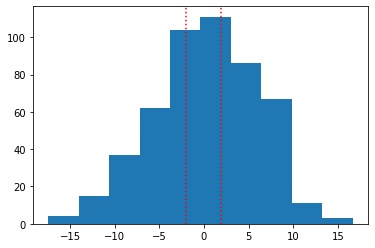

In [25]:
tstats = tibo_question3(data)
plt.hist(tstats)
plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

In [27]:
(np.abs(tstats)>1.96).mean()

0.726

Thus, in about 73% of cases we reject the null that the policy has no significant effect on log(wages). When we use the wage data, the observations are not iid (as in Q2 above). This is why the t-statistic is significant much more than in Q2. Because people from the same state likely have correlated wages, we should instead turn to clustering.

## Heteroskedastic errors

Now we want to simulate heteroskedastic robust standard errors which requires us to use some co-variates. We then want to repeat the previous procedure, but we are going to use a different code for simulation and a new test for the significance. `statsmodels` can do that for you using the `cov_type` argument of the `fit` method.

We want to check this by simulating from a model with heteroskedesatic errors. To do so we are going to use linear model for the variance:

$$ y_{i} = 0 + s(x_i) \cdot \epsilon_i$$

We are going to use a linear specification for both $m(x_i)$ and $s^2(x_i)$. 

 1. run the following regression `lnwage ~ yrseduc + age + age^2` to bet the $m(x_i) = x_i' \beta$ where the $x_i$ are education, age and age squared. 
 2. extract the residuals $\hat{u}_i$ from the previous regression. Then regress $\hat{u}^2_i$ on `yrseduc + age + age^2`, to get the $s^2(x_i) = x_i' \gamma$ model.
 2. using $m(x_i) = x_i' \beta$ and $s^2(x_i) = x_i' \gamma$, construct $ y_{i} = 0 + s(x_i) \cdot \epsilon_i$ where $\epsilon_i$ is drawn iid Normal(0,1).
 5. replicate this 500 times, evaluate the significance of `fp` using heteroskedastic roduct inference by calling `.fit(cov_type='HC0')`, also save without using the robust errors.

Question 4:<br>
Follow the steps and report the distributions of t-stats, as well as the rejection rates for each of the two variance specifications.

In [9]:
## T-statistics
from tqdm import tqdm

def tibo_question4(data):
    start = time.time()
    tstats, tstats_robust = [], []
    for iter in tqdm(range(0, 500)):
        reg = smf.ols('lnwage ~ yrseduc + age + age2', data=data).fit()
        data = data.assign(resid2 = reg.resid**2) 
        reg2 = smf.ols('resid2 ~ yrseduc + age + age2',data=data).fit()
        #data = data.assign(y2 = reg.fittedvalues + (reg2.fittedvalues**0.5)*np.random.normal(size=len(data))) 
        data = data.assign(y2 = (reg2.fittedvalues**0.5)*np.random.normal(size=len(data))) 
        results = smf.ols('y2 ~ fp', data=data).fit()
        results_robust = smf.ols('y2 ~ fp', data=data).fit(cov_type='HC0')
        tstats.append(results.tvalues[1])
        tstats_robust.append(results_robust.tvalues[1])
    end = time.time()
    print("Time: ", round((end - start) / 60, 2), "min")
    return tstats, tstats_robust

100%|██████████| 500/500 [12:53<00:00,  1.55s/it]  

Time:  12.9 min


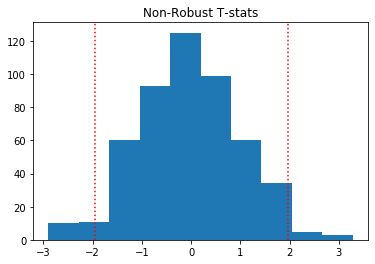

In [10]:
#Rejection Rates -- non-robust tstats
tstats, tstats_robust = tibo_question4(data)

plt.hist(tstats)
plt.title("Non-Robust T-stats")

plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

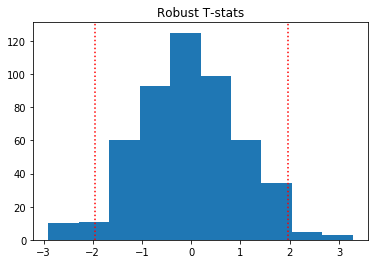

In [11]:
plt.hist(tstats_robust)
plt.title("Robust T-stats")

plt.axvline(1.96,color='red',linestyle=":")
plt.axvline(-1.96,color='red',linestyle=":")

In [12]:
print("Rejection Rate Regular T-stats: ", (np.abs(tstats)>1.96).mean())
print("Rejection Rate Robust T-stats: ", (np.abs(tstats_robust)>1.96).mean())

Rejection Rate Regular T-stats:  0.052
Rejection Rate Robust T-stats:  0.052


## State clustered errors

We are going to simulate correlated error within state. To do so we continue to draw independent error terms $u_i$ but we add to them a common draw at the state level. In practice you can do that by doing similar to drawing the `fp`. We then create the outcome as 

$$y_{ig} = (1-\rho) u_i + \rho v_g $$

Here is a way of doing this: 

In [115]:
rho=0.5
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

,year,statefip,wtsupp,age,sex,yrseduc,wage_per_hour,lnwage,age2,fp,decile,u,v
0,2012,Maine,569.43,44,Female,14.0,7.020000,1.948763,1936.0,True,50,0.314822,0.166238
1,2012,Maine,595.47,25,Male,16.0,2.117143,0.750067,625.0,True,30,1.375460,0.696557
2,2012,Maine,635.66,61,Female,16.0,16.672501,2.813761,3721.0,True,70,0.726437,0.372046
3,2012,Maine,635.66,62,Male,16.0,17.784000,2.878299,3844.0,True,70,1.041121,0.529387
4,2012,Maine,513.39,25,Female,12.0,9.633000,2.265195,625.0,True,30,-0.786331,-0.384339


Question 5: <br>
First, explain the `groupby` expression. Next find another way of doing line 2 and 3, but try to minize the number of characters (see [python golfing](https://www.geeksforgeeks.org/code-golfing-in-python/) or more generaly [wikipedia](https://en.wikipedia.org/wiki/Code_golf)).

The groupby expression splits the dataframe by state, and allows us to apply our function to each state individually. This is needed to assign an error term at the state level.

In [123]:
#Abbreviated
rho = 0.5
n = np.random.normal(size=len(data))
data['y'] = (1-rho)*n+rho*n[pd.factorize(data.statefip)[0]]

In [117]:
#test
n = np.random.normal(size=len(data))
data['u'] = n
data['v'] = n[pd.factorize(data.statefip)[0]]
data['y'] = (1-rho)*n+rho*n[pd.factorize(data.statefip)[0]]
data.head() #If we should not pull from same list n, change first n to n[::-1], size=len(data)*2

,year,statefip,wtsupp,age,sex,yrseduc,wage_per_hour,lnwage,age2,fp,u,v,y
0,2012,Maine,569.43,44,Female,14.0,7.020000,1.948763,1936.0,True,-0.235821,-0.235821,-0.235821
1,2012,Maine,595.47,25,Male,16.0,2.117143,0.750067,625.0,True,-1.316322,-0.235821,-0.776071
2,2012,Maine,635.66,61,Female,16.0,16.672501,2.813761,3721.0,True,1.322015,-0.235821,0.543097
3,2012,Maine,635.66,62,Male,16.0,17.784000,2.878299,3844.0,True,0.906937,-0.235821,0.335558
4,2012,Maine,513.39,25,Female,12.0,9.633000,2.265195,625.0,True,1.639615,-0.235821,0.701897


Groupby is somewhat like a pivot table.

Before we get started estimating the effect of the policy, let's write a function that computes the within state correlation in the error term. 

To that end draw 500 pairs of people where the 2 people in a pair belong to the same state. This gives you 2 vector of length 500. Compute the correlation between these 2 vectors. Use the `sample` and `query` methods of `pandas`. Similarly construct a placebo function that just takes random pairs of workers without imposing that they come from the same state.

Question 6: <br> 
Write your own version of the `tibo_pair_cor` and `tibo_cor_placebo` functions.

In [235]:
def tibo_pair_cor(data):
    l1, l2 = [], []
    for iter in range(0, 500):
        a = data.sample().reset_index()
        b = data.query("statefip == @a.statefip[0]").sample().reset_index()
        l1.append(a.y[0]) #find correlation between y's
        l2.append(b.y[0])
    return np.corrcoef(l1,l2)[0,1]

def tibo_pair_cor_placebo(data):
    l1, l2 = data.sample(500)['y'], data.sample(500)['y']
    return np.corrcoef(l1,l2)[0,1]

In [237]:
rho=0.5
data['u'] = np.random.normal(size=len(data))
data['y'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(tibo_pair_cor(data))
print(tibo_pair_cor_placebo(data))

rho=0.8
data['u'] = np.random.normal(size=len(data))
data['y'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

print(tibo_pair_cor(data))
print(tibo_pair_cor_placebo(data))

0.3885625426251621
0.021181384513487528
0.923442424530743
0.009290175384837762


We are then going to replicate the data construction 500 times.

Question 7: <br> 
For $\rho=0.2,0.5,0.8$ run 500 replications and report the proportion at each value of $\rho$ for which the coefficient on$\text{fp}$ is significant at 5%. Report the results for three different regression using regular `fit`, using `cov_type='HC0'` and using `cov_type='cluster'`.

<font color='red'> NOTE: TAKES VERY LONG </font>

In [8]:
def tibo_question7(data):
    def cluster(data,rho):
        tstats, tstats_robust, tstats_cluster = [], [], []
        for iter in range(0,500):
            data['u'] = np.random.normal(size=len(data))
            data['y'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))
            results = smf.ols('y ~ fp', data=data).fit()
            results_robust = smf.ols('y ~ fp', data=data).fit(cov_type = 'HC0')
            results_cluster = smf.ols('y ~ fp', data=data).fit(cov_type='cluster', cov_kwds={"groups":data['statefip']})
            tstats.append(results.tvalues[1])
            tstats_robust.append(results_robust.tvalues[1])
            tstats_cluster.append(results_cluster.tvalues[1])
        print("Rho: ", rho, " Fit: ", "Non-Robust", " Prop. Significant: ", (np.abs(tstats)>1.96).mean())
        print("Rho: ", rho, " Fit: ", "Robust", " Prop. Significant: ", (np.abs(tstats_robust)>1.96).mean())
        print("Rho: ", rho, " Fit: ", "Cluster", " Prop. Significant: ", (np.abs(tstats_cluster)>1.96).mean())
        #return tstats, tstats_robust, tstats_cluster
    
    start = time.time()
    rhos = [0.2,0.5,0.8]
    for r in rhos:
        cluster(data,r)
    end = time.time()
    print("Time: ", round((end - start) / 60, 2), "min")

In [9]:
tibo_question7(data)

Rho:  0.2  Fit:  Non-Robust  Prop. Significant:  0.846
Rho:  0.2  Fit:  Robust  Prop. Significant:  0.846
Rho:  0.2  Fit:  Cluster  Prop. Significant:  0.082
Rho:  0.5  Fit:  Non-Robust  Prop. Significant:  0.94
Rho:  0.5  Fit:  Robust  Prop. Significant:  0.94
Rho:  0.5  Fit:  Cluster  Prop. Significant:  0.07
Rho:  0.8  Fit:  Non-Robust  Prop. Significant:  0.958
Rho:  0.8  Fit:  Robust  Prop. Significant:  0.958
Rho:  0.8  Fit:  Cluster  Prop. Significant:  0.074
Time:  135.53 min


As expected, the clustered t-statistics are significant much less frequently than in the other, non-clustered cases.

In [51]:
# here is an example of clustered errors 
rho=0.5
data['u'] = np.random.normal(size=len(data))
data['v'] = data.groupby('statefip')['u'].transform(lambda x : (1-rho)*x.to_numpy() + rho*np.random.normal(size=1))

data['y'] =  data.v
results = smf.ols('y ~ fp', data=data).fit(cov_type='cluster',cov_kwds={"groups":data['statefip']})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                    0.9980
Date:                Fri, 24 Apr 2020   Prob (F-statistic):              0.323
Time:                        16:13:48   Log-Likelihood:                -71205.
No. Observations:               65685   AIC:                         1.424e+05
Df Residuals:                   65683   BIC:                         1.424e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0755      0.087      0.870      0.3

In [52]:
# and here the regression without clustered standard errors
results = smf.ols('y ~ fp', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     686.9
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          1.28e-150
Time:                        16:13:53   Log-Likelihood:                -71205.
No. Observations:               65685   AIC:                         1.424e+05
Df Residuals:                   65683   BIC:                         1.424e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0755      0.004     20.671      0.0